In [27]:
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [81]:
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
import tqdm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [109]:
# List of stock tickers
stocks = ["AAPL", "TSLA", "JPM", "KO", "XOM", "PG", "WMT", "BA", "CVX", "GS",
          "PFE", "JNJ", "V", "MMM", "GE", "IBM", "MCD", "T", "AXP", "NKE"]

# Download historical data from Yahoo Finance
start_date = "2015-01-01"
end_date = "2023-12-31"

data = yf.download(stocks, start=start_date, end=end_date, group_by="ticker", auto_adjust=False)

# Extract adjusted close prices for all stocks
adj_close_prices = data.xs(key='Adj Close', axis=1, level=1)
# Calculate daily returns
daily_returns = adj_close_prices.pct_change().dropna()  # Percentage change

# Calculate expected returns (mean daily returns)
expected_returns = daily_returns.mean()

# Covariance matrix of daily returns
covariance_matrix = daily_returns.cov()

[*********************100%***********************]  20 of 20 completed


In [110]:
# Functions to calculate techincal indicators

def calculate_sma(data, window=20):
    return data.rolling(window=window).mean()

def calculate_ema(data, span=20):
    return data.ewm(span=span, adjust=False).mean()

def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_bollinger_bands(data, window=20, num_std_dev=2):
    sma = calculate_sma(data, window)
    rolling_std = data.rolling(window=window).std()
    upper_band = sma + (rolling_std * num_std_dev)
    lower_band = sma - (rolling_std * num_std_dev)
    return sma, upper_band, lower_band

def calculate_macd(data, fast_period=12, slow_period=26, signal_period=9):
    fast_ema = calculate_ema(data, span=fast_period)
    slow_ema = calculate_ema(data, span=slow_period)
    macd_line = fast_ema - slow_ema
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    return macd_line, signal_line

def calculate_volatility(data, window=20):
    return data.pct_change().rolling(window).std()

In [111]:
features = []

for stock in stocks:
    stock_data = data[stock]
    adj_close = stock_data['Adj Close']
    
    # Calculate indicators
    stock_data['SMA_20'] = calculate_sma(adj_close)
    stock_data['EMA_20'] = calculate_ema(adj_close)
    stock_data['RSI_14'] = calculate_rsi(adj_close)
    stock_data['BB_Middle'], stock_data['BB_Upper'], stock_data['BB_Lower'] = calculate_bollinger_bands(adj_close)
    stock_data['MACD'], stock_data['Signal_Line'] = calculate_macd(adj_close)
    stock_data['Volatility'] = calculate_volatility(adj_close)
    
    # Add to features list
    features.append(stock_data.dropna())
    
# Combine all stock data
combined_data = pd.concat(features, keys=stocks)




/var/folders/wp/0q2ph3rx2d3df103v6qhk3c00000gn/T/ipykernel_2468/3658593025.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['SMA_20'] = calculate_sma(adj_close)
/var/folders/wp/0q2ph3rx2d3df103v6qhk3c00000gn/T/ipykernel_2468/3658593025.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['EMA_20'] = calculate_ema(adj_close)
/var/folders/wp/0q2ph3rx2d3df103v6qhk3c00000gn/T/ipykernel_2468/3658593025.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [121]:
# Define features for the model
indicators = ['SMA_20', 'EMA_20', 'RSI_14', 'BB_Middle', 'BB_Upper', 'BB_Lower', 
              'MACD', 'Signal_Line', 'Volatility']
X = combined_data[indicators].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Target portfolio weights (assume pre-computed weights for now)
n_assets = len(stocks)
y = np.tile(np.ones(n_assets) / n_assets, (len(X_scaled), 1))  # Dummy equal weights

In [118]:
print(X)

Price                SMA_20      EMA_20     RSI_14   BB_Middle    BB_Upper  \
     Date                                                                    
AAPL 2015-02-02   24.715614   25.005628  66.039690   24.715614   26.492460   
     2015-02-03   24.853533   25.137821  64.899252   24.853533   26.703989   
     2015-02-04   25.001461   25.276704  66.956252   25.001461   26.914575   
     2015-02-05   25.142309   25.420438  75.500394   25.142309   27.147905   
     2015-02-06   25.225832   25.529003  74.982979   25.225832   27.324159   
...                     ...         ...        ...         ...         ...   
NKE  2023-12-22  113.690604  113.543419  37.308116  113.690604  123.909791   
     2023-12-26  113.711256  112.792950  36.694285  113.711256  123.860053   
     2023-12-27  113.649870  112.031042  33.941349  113.649870  124.007238   
     2023-12-28  113.592173  111.499137  39.435638  113.592173  124.103160   
     2023-12-29  113.527124  110.994601  36.654550  113.527124  

In [146]:
# Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

# DataLoaders for batching
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Convert expected returns and covariance matrix to tensors
expected_returns_tensor = torch.tensor(expected_returns.values, dtype=torch.float32)
covariance_tensor = torch.tensor(covariance_matrix.values, dtype=torch.float32)


In [82]:
class SharpeRatioLoss(nn.Module):
    def __init__(self, risk_free_rate=0.01):
        super(SharpeRatioLoss, self).__init__()
        self.risk_free_rate = risk_free_rate

    def forward(self, weights, expected_returns, covariance_matrix):
        # Portfolio return: w^T * mu
        portfolio_return = torch.sum(weights * expected_returns, dim=1)  # Batch-wise computation
        
        # Portfolio risk: sqrt(w^T * Sigma * w)
        portfolio_variance = torch.matmul(weights.unsqueeze(1), torch.matmul(covariance_matrix, weights.unsqueeze(2))).squeeze()
        portfolio_std = torch.sqrt(portfolio_variance)
        
        # Sharpe Ratio
        sharpe_ratio = (portfolio_return - self.risk_free_rate) / portfolio_std
        
        # Loss is negative Sharpe ratio
        loss = -torch.mean(sharpe_ratio)  # Minimize negative Sharpe ratio
        return loss

In [127]:
class PortfolioFCN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PortfolioFCN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Linear(128, output_dim),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Softmax(dim=1)  # Ensures weights sum to 1
        )

    def forward(self, x):
        return self.network(x)

In [84]:
def train_weights(train_loader, val_loader, model, loss_func, optimizer, covariance_tensor, expected_returns_tensor, epochs=50):
    train_loss_list = np.zeros((epochs,))
    val_loss_list = np.zeros((epochs,))
    
    for epoch in tqdm.trange(epochs):
        model.train()
        train_loss = 0.0
        
        for X_batch, _ in train_loader:  # No target weights (goal is optimization)
            optimizer.zero_grad()
            
            # Predict portfolio weights
            predicted_weights = model(X_batch)
            
            # Compute loss using Sharpe Ratio loss
            loss = loss_func(predicted_weights, expected_returns_tensor, covariance_tensor)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss_list[epoch] = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, _ in val_loader:
                predicted_weights = model(X_batch)
                loss = loss_func(predicted_weights, expected_returns_tensor, covariance_tensor)
                val_loss += loss.item()
        
        val_loss_list[epoch] = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_loss_list, val_loss_list


In [85]:
def test_weights(test_loader, model, criterion, covariance_tensor, expected_returns_tensor):
    model.eval()
    test_loss = 0.0
    all_weights = []

    with torch.no_grad():
        for X_batch, _ in test_loader:
            predicted_weights = model(X_batch)
            all_weights.append(predicted_weights.numpy())  # Save weights
            loss = criterion(predicted_weights, expected_returns_tensor, covariance_tensor)
            test_loss += loss.item()
    
    test_loss /= len(test_loader)
    all_weights = np.vstack(all_weights)  # Combine all weights from batches
    print(f"Test Loss: {test_loss:.4f}")
    return all_weights


  2%|▏         | 1/50 [00:01<00:55,  1.14s/it]

Epoch 1, Train Loss: 213.3059, Val Loss: 64.1680


  4%|▍         | 2/50 [00:02<00:52,  1.10s/it]

Epoch 2, Train Loss: 213.1238, Val Loss: 64.1680


  6%|▌         | 3/50 [00:03<00:58,  1.25s/it]

Epoch 3, Train Loss: 213.0821, Val Loss: 64.1680


  8%|▊         | 4/50 [00:04<00:56,  1.22s/it]

Epoch 4, Train Loss: 213.0697, Val Loss: 64.1680


 10%|█         | 5/50 [00:05<00:51,  1.15s/it]

Epoch 5, Train Loss: 212.4814, Val Loss: 64.1680


 12%|█▏        | 6/50 [00:06<00:48,  1.11s/it]

Epoch 6, Train Loss: 213.6136, Val Loss: 64.1680


 14%|█▍        | 7/50 [00:07<00:46,  1.09s/it]

Epoch 7, Train Loss: 213.1219, Val Loss: 64.1680


 16%|█▌        | 8/50 [00:08<00:45,  1.08s/it]

Epoch 8, Train Loss: 213.2987, Val Loss: 64.1680


 18%|█▊        | 9/50 [00:10<00:47,  1.15s/it]

Epoch 9, Train Loss: 213.9007, Val Loss: 64.1680


 20%|██        | 10/50 [00:11<00:44,  1.12s/it]

Epoch 10, Train Loss: 212.7841, Val Loss: 64.1680


 22%|██▏       | 11/50 [00:12<00:43,  1.11s/it]

Epoch 11, Train Loss: 212.4317, Val Loss: 64.1680


 24%|██▍       | 12/50 [00:13<00:41,  1.09s/it]

Epoch 12, Train Loss: 213.2635, Val Loss: 64.1680


 26%|██▌       | 13/50 [00:14<00:39,  1.08s/it]

Epoch 13, Train Loss: 213.7119, Val Loss: 64.1680


 28%|██▊       | 14/50 [00:15<00:38,  1.06s/it]

Epoch 14, Train Loss: 212.6529, Val Loss: 64.1680


 30%|███       | 15/50 [00:16<00:36,  1.06s/it]

Epoch 15, Train Loss: 212.9639, Val Loss: 64.1680


 32%|███▏      | 16/50 [00:17<00:35,  1.05s/it]

Epoch 16, Train Loss: 213.7027, Val Loss: 64.1680


 34%|███▍      | 17/50 [00:18<00:34,  1.04s/it]

Epoch 17, Train Loss: 213.5211, Val Loss: 64.1680


 36%|███▌      | 18/50 [00:19<00:34,  1.08s/it]

Epoch 18, Train Loss: 212.3597, Val Loss: 64.1680


 38%|███▊      | 19/50 [00:20<00:33,  1.07s/it]

Epoch 19, Train Loss: 213.0829, Val Loss: 64.1680


 40%|████      | 20/50 [00:21<00:31,  1.06s/it]

Epoch 20, Train Loss: 213.2157, Val Loss: 64.1680


 42%|████▏     | 21/50 [00:22<00:30,  1.05s/it]

Epoch 21, Train Loss: 212.6685, Val Loss: 64.1680


 44%|████▍     | 22/50 [00:23<00:29,  1.04s/it]

Epoch 22, Train Loss: 213.2507, Val Loss: 64.1680


 46%|████▌     | 23/50 [00:24<00:28,  1.04s/it]

Epoch 23, Train Loss: 213.5699, Val Loss: 64.1680


 48%|████▊     | 24/50 [00:26<00:27,  1.04s/it]

Epoch 24, Train Loss: 213.5872, Val Loss: 64.1680


 50%|█████     | 25/50 [00:27<00:25,  1.04s/it]

Epoch 25, Train Loss: 213.4436, Val Loss: 64.1680


 52%|█████▏    | 26/50 [00:28<00:24,  1.04s/it]

Epoch 26, Train Loss: 213.0259, Val Loss: 64.1680


 54%|█████▍    | 27/50 [00:29<00:23,  1.03s/it]

Epoch 27, Train Loss: 212.9136, Val Loss: 64.1680


 56%|█████▌    | 28/50 [00:30<00:23,  1.07s/it]

Epoch 28, Train Loss: 213.4779, Val Loss: 64.1680


 58%|█████▊    | 29/50 [00:31<00:22,  1.06s/it]

Epoch 29, Train Loss: 212.8396, Val Loss: 64.1680


 60%|██████    | 30/50 [00:32<00:21,  1.05s/it]

Epoch 30, Train Loss: 213.2117, Val Loss: 64.1680


 62%|██████▏   | 31/50 [00:33<00:19,  1.05s/it]

Epoch 31, Train Loss: 213.4576, Val Loss: 64.1680


 64%|██████▍   | 32/50 [00:34<00:18,  1.04s/it]

Epoch 32, Train Loss: 212.4637, Val Loss: 64.1680


 66%|██████▌   | 33/50 [00:35<00:17,  1.04s/it]

Epoch 33, Train Loss: 213.3498, Val Loss: 64.1680


 68%|██████▊   | 34/50 [00:36<00:16,  1.04s/it]

Epoch 34, Train Loss: 212.7603, Val Loss: 64.1680


 70%|███████   | 35/50 [00:37<00:16,  1.08s/it]

Epoch 35, Train Loss: 212.9285, Val Loss: 64.1680


 72%|███████▏  | 36/50 [00:38<00:15,  1.08s/it]

Epoch 36, Train Loss: 213.4649, Val Loss: 64.1680


 74%|███████▍  | 37/50 [00:39<00:14,  1.08s/it]

Epoch 37, Train Loss: 213.3809, Val Loss: 64.1680


 76%|███████▌  | 38/50 [00:40<00:12,  1.08s/it]

Epoch 38, Train Loss: 212.9543, Val Loss: 64.1680


 78%|███████▊  | 39/50 [00:41<00:11,  1.06s/it]

Epoch 39, Train Loss: 213.3471, Val Loss: 64.1680


 80%|████████  | 40/50 [00:42<00:10,  1.06s/it]

Epoch 40, Train Loss: 212.4826, Val Loss: 64.1680


 82%|████████▏ | 41/50 [00:44<00:09,  1.06s/it]

Epoch 41, Train Loss: 213.0265, Val Loss: 64.1680


 84%|████████▍ | 42/50 [00:45<00:08,  1.06s/it]

Epoch 42, Train Loss: 213.1120, Val Loss: 64.1680


 86%|████████▌ | 43/50 [00:46<00:07,  1.06s/it]

Epoch 43, Train Loss: 213.5672, Val Loss: 64.1680


 88%|████████▊ | 44/50 [00:47<00:06,  1.05s/it]

Epoch 44, Train Loss: 212.8138, Val Loss: 64.1680


 90%|█████████ | 45/50 [00:48<00:05,  1.05s/it]

Epoch 45, Train Loss: 212.9718, Val Loss: 64.1680


 92%|█████████▏| 46/50 [00:49<00:04,  1.10s/it]

Epoch 46, Train Loss: 213.1327, Val Loss: 64.1680


 94%|█████████▍| 47/50 [00:50<00:03,  1.09s/it]

Epoch 47, Train Loss: 213.2387, Val Loss: 64.1680


 96%|█████████▌| 48/50 [00:51<00:02,  1.09s/it]

Epoch 48, Train Loss: 212.8437, Val Loss: 64.1680


 98%|█████████▊| 49/50 [00:52<00:01,  1.08s/it]

Epoch 49, Train Loss: 213.0241, Val Loss: 64.1680


100%|██████████| 50/50 [00:53<00:00,  1.07s/it]

Epoch 50, Train Loss: 213.5498, Val Loss: 64.1680


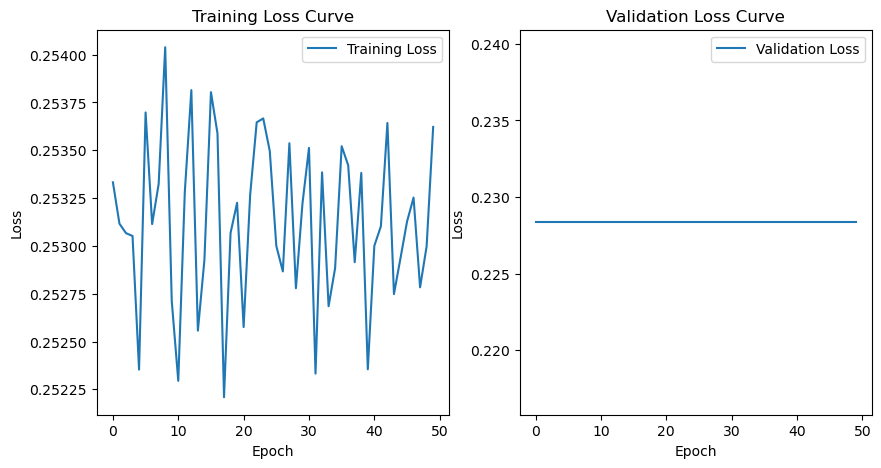

In [147]:
# Initialize model, criterion, and optimizer
model = PortfolioFCN(input_dim=len(indicators), output_dim=len(stocks))
criterion = SharpeRatioLoss(risk_free_rate=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
train_losses, val_losses = train_weights(train_loader, val_loader, model, criterion, optimizer, covariance_tensor, expected_returns_tensor, epochs=50)

# Plot loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Curve')
plt.legend()

# Save the figure as a PDF 
plt.savefig("base_model.pdf")


In [148]:
# Test the model
weights = test_weights(test_loader, model, criterion, covariance_tensor, expected_returns_tensor)
print("Optimized Portfolio Weights:", weights)

print(weights.shape)


Test Loss: 0.2284
Optimized Portfolio Weights: [[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
(8976, 20)


  2%|▏         | 1/50 [00:01<00:54,  1.12s/it]

Epoch 1, Train Loss: 331.4889, Val Loss: 101.4745


  4%|▍         | 2/50 [00:02<00:55,  1.16s/it]

Epoch 2, Train Loss: 311.9859, Val Loss: 101.4560


  6%|▌         | 3/50 [00:03<00:55,  1.18s/it]

Epoch 3, Train Loss: 311.3237, Val Loss: 101.4521


  8%|▊         | 4/50 [00:04<00:53,  1.17s/it]

Epoch 4, Train Loss: 312.0601, Val Loss: 101.4509


 10%|█         | 5/50 [00:05<00:51,  1.15s/it]

Epoch 5, Train Loss: 311.9959, Val Loss: 101.4503


 12%|█▏        | 6/50 [00:06<00:49,  1.12s/it]

Epoch 6, Train Loss: 312.0831, Val Loss: 101.4501


 14%|█▍        | 7/50 [00:08<00:49,  1.15s/it]

Epoch 7, Train Loss: 312.3804, Val Loss: 101.4499


 16%|█▌        | 8/50 [00:09<00:49,  1.17s/it]

Epoch 8, Train Loss: 311.9357, Val Loss: 101.4498


 18%|█▊        | 9/50 [00:10<00:48,  1.19s/it]

Epoch 9, Train Loss: 311.7100, Val Loss: 101.4498


 20%|██        | 10/50 [00:11<00:46,  1.16s/it]

Epoch 10, Train Loss: 312.3055, Val Loss: 101.4498


 22%|██▏       | 11/50 [00:12<00:47,  1.21s/it]

Epoch 11, Train Loss: 312.1386, Val Loss: 101.4497


 24%|██▍       | 12/50 [00:14<00:44,  1.18s/it]

Epoch 12, Train Loss: 312.1918, Val Loss: 101.4497


 26%|██▌       | 13/50 [00:15<00:42,  1.15s/it]

Epoch 13, Train Loss: 312.0554, Val Loss: 101.4497


 28%|██▊       | 14/50 [00:16<00:40,  1.14s/it]

Epoch 14, Train Loss: 312.0517, Val Loss: 101.4497


 30%|███       | 15/50 [00:17<00:39,  1.14s/it]

Epoch 15, Train Loss: 311.8670, Val Loss: 101.4497


 32%|███▏      | 16/50 [00:18<00:38,  1.12s/it]

Epoch 16, Train Loss: 311.9357, Val Loss: 101.4497


 34%|███▍      | 17/50 [00:19<00:36,  1.11s/it]

Epoch 17, Train Loss: 311.7627, Val Loss: 101.4497


 36%|███▌      | 18/50 [00:20<00:35,  1.10s/it]

Epoch 18, Train Loss: 311.7658, Val Loss: 101.4497


 38%|███▊      | 19/50 [00:21<00:34,  1.10s/it]

Epoch 19, Train Loss: 312.2528, Val Loss: 101.4497


 40%|████      | 20/50 [00:22<00:32,  1.09s/it]

Epoch 20, Train Loss: 312.0850, Val Loss: 101.4497


 42%|████▏     | 21/50 [00:23<00:31,  1.09s/it]

Epoch 21, Train Loss: 312.0228, Val Loss: 101.4497


 44%|████▍     | 22/50 [00:24<00:29,  1.07s/it]

Epoch 22, Train Loss: 311.7624, Val Loss: 101.4497


 46%|████▌     | 23/50 [00:25<00:28,  1.07s/it]

Epoch 23, Train Loss: 312.1370, Val Loss: 101.4497


 48%|████▊     | 24/50 [00:27<00:27,  1.07s/it]

Epoch 24, Train Loss: 311.9444, Val Loss: 101.4497


 50%|█████     | 25/50 [00:28<00:26,  1.07s/it]

Epoch 25, Train Loss: 311.6466, Val Loss: 101.4497


 52%|█████▏    | 26/50 [00:29<00:26,  1.09s/it]

Epoch 26, Train Loss: 311.9425, Val Loss: 101.4497


 54%|█████▍    | 27/50 [00:30<00:24,  1.08s/it]

Epoch 27, Train Loss: 312.1941, Val Loss: 101.4497


 56%|█████▌    | 28/50 [00:31<00:23,  1.08s/it]

Epoch 28, Train Loss: 311.7876, Val Loss: 101.4497


 58%|█████▊    | 29/50 [00:32<00:22,  1.08s/it]

Epoch 29, Train Loss: 311.7290, Val Loss: 101.4497


 60%|██████    | 30/50 [00:33<00:21,  1.09s/it]

Epoch 30, Train Loss: 312.1648, Val Loss: 101.4497


 62%|██████▏   | 31/50 [00:34<00:20,  1.09s/it]

Epoch 31, Train Loss: 311.9514, Val Loss: 101.4497


 64%|██████▍   | 32/50 [00:35<00:19,  1.08s/it]

Epoch 32, Train Loss: 311.9971, Val Loss: 101.4497


 66%|██████▌   | 33/50 [00:36<00:18,  1.08s/it]

Epoch 33, Train Loss: 311.6724, Val Loss: 101.4497


 68%|██████▊   | 34/50 [00:37<00:17,  1.07s/it]

Epoch 34, Train Loss: 312.1004, Val Loss: 101.4497


 70%|███████   | 35/50 [00:38<00:16,  1.07s/it]

Epoch 35, Train Loss: 312.0312, Val Loss: 101.4497


 72%|███████▏  | 36/50 [00:40<00:15,  1.09s/it]

Epoch 36, Train Loss: 311.5545, Val Loss: 101.4497


 74%|███████▍  | 37/50 [00:41<00:14,  1.09s/it]

Epoch 37, Train Loss: 311.9257, Val Loss: 101.4497


 76%|███████▌  | 38/50 [00:42<00:13,  1.09s/it]

Epoch 38, Train Loss: 312.1547, Val Loss: 101.4497


 78%|███████▊  | 39/50 [00:43<00:11,  1.09s/it]

Epoch 39, Train Loss: 312.5178, Val Loss: 101.4497


 80%|████████  | 40/50 [00:44<00:10,  1.08s/it]

Epoch 40, Train Loss: 311.8317, Val Loss: 101.4497


 82%|████████▏ | 41/50 [00:45<00:09,  1.09s/it]

Epoch 41, Train Loss: 312.0812, Val Loss: 101.4497


 84%|████████▍ | 42/50 [00:46<00:08,  1.08s/it]

Epoch 42, Train Loss: 311.9877, Val Loss: 101.4497


 86%|████████▌ | 43/50 [00:47<00:07,  1.08s/it]

Epoch 43, Train Loss: 311.9497, Val Loss: 101.4497


 88%|████████▊ | 44/50 [00:48<00:06,  1.09s/it]

Epoch 44, Train Loss: 311.9989, Val Loss: 101.4497


 90%|█████████ | 45/50 [00:49<00:05,  1.09s/it]

Epoch 45, Train Loss: 312.3059, Val Loss: 101.4497


 92%|█████████▏| 46/50 [00:50<00:04,  1.10s/it]

Epoch 46, Train Loss: 311.9221, Val Loss: 101.4497


 94%|█████████▍| 47/50 [00:51<00:03,  1.09s/it]

Epoch 47, Train Loss: 311.7606, Val Loss: 101.4497


 96%|█████████▌| 48/50 [00:53<00:02,  1.10s/it]

Epoch 48, Train Loss: 311.6420, Val Loss: 101.4497


 98%|█████████▊| 49/50 [00:54<00:01,  1.09s/it]

Epoch 49, Train Loss: 311.7548, Val Loss: 101.4497


100%|██████████| 50/50 [00:55<00:00,  1.11s/it]

Epoch 50, Train Loss: 311.8792, Val Loss: 101.4497


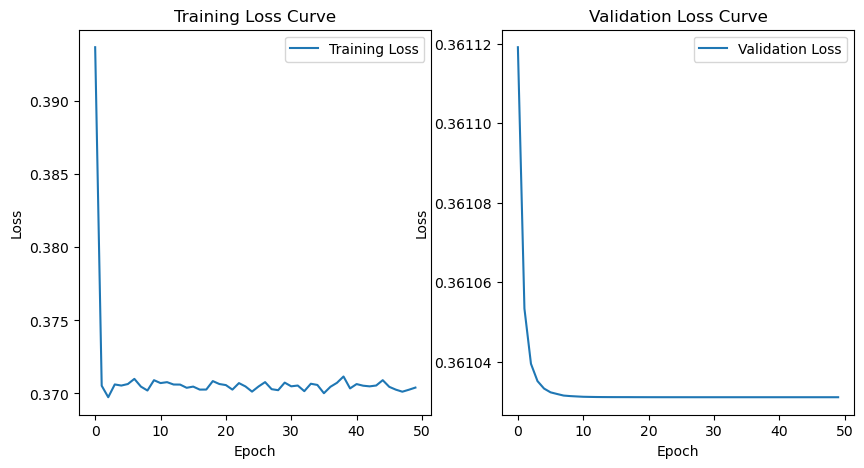

In [149]:
# Initialize model, criterion, and optimizer
model = PortfolioFCN(input_dim=len(indicators), output_dim=len(stocks))
criterion = SharpeRatioLoss(risk_free_rate=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train_losses, val_losses = train_weights(train_loader, val_loader, model, criterion, optimizer, covariance_tensor, expected_returns_tensor, epochs=50)

# Plot loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Curve')
plt.legend()

# Save the figure as a PDF 
plt.savefig("lower_learning_rate_1.pdf")

In [150]:
# Test the model
weights = test_weights(test_loader, model, criterion, covariance_tensor, expected_returns_tensor)
print("Optimized Portfolio Weights:", weights)

print(weights.shape)

Test Loss: 0.3610
Optimized Portfolio Weights: [[1.4012985e-45 2.2838146e-31 1.4012985e-45 ... 1.4012985e-45
  1.4012985e-45 1.4012985e-45]
 [1.0261655e-38 1.0374128e-26 1.0261655e-38 ... 1.0261655e-38
  1.0261655e-38 1.0261655e-38]
 [0.0000000e+00 7.4959094e-32 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [1.3748839e-33 3.2365713e-23 1.3748839e-33 ... 1.3748839e-33
  1.3748839e-33 1.3748839e-33]
 [9.5988945e-43 1.7446491e-29 9.5988945e-43 ... 9.5988945e-43
  9.5988945e-43 9.5988945e-43]
 [1.2835894e-42 1.9588099e-29 1.2835894e-42 ... 1.2835894e-42
  1.2835894e-42 1.2835894e-42]]
(8976, 20)


  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

Epoch 1, Train Loss: 459.2680, Val Loss: 104.5452


  4%|▍         | 2/50 [00:02<00:58,  1.21s/it]

Epoch 2, Train Loss: 302.9836, Val Loss: 102.1032


  6%|▌         | 3/50 [00:03<00:54,  1.17s/it]

Epoch 3, Train Loss: 298.4739, Val Loss: 101.7213


  8%|▊         | 4/50 [00:04<00:53,  1.17s/it]

Epoch 4, Train Loss: 296.2307, Val Loss: 101.5862


 10%|█         | 5/50 [00:05<00:53,  1.18s/it]

Epoch 5, Train Loss: 295.8008, Val Loss: 101.5245


 12%|█▏        | 6/50 [00:07<00:53,  1.22s/it]

Epoch 6, Train Loss: 294.8948, Val Loss: 101.4921


 14%|█▍        | 7/50 [00:08<00:51,  1.21s/it]

Epoch 7, Train Loss: 294.9873, Val Loss: 101.4744


 16%|█▌        | 8/50 [00:09<00:50,  1.20s/it]

Epoch 8, Train Loss: 294.7903, Val Loss: 101.4657


 18%|█▊        | 9/50 [00:10<00:50,  1.24s/it]

Epoch 9, Train Loss: 295.0692, Val Loss: 101.4602


 20%|██        | 10/50 [00:12<00:47,  1.20s/it]

Epoch 10, Train Loss: 294.6150, Val Loss: 101.4563


 22%|██▏       | 11/50 [00:13<00:46,  1.18s/it]

Epoch 11, Train Loss: 294.5637, Val Loss: 101.4541


 24%|██▍       | 12/50 [00:14<00:43,  1.16s/it]

Epoch 12, Train Loss: 294.9804, Val Loss: 101.4526


 26%|██▌       | 13/50 [00:15<00:42,  1.16s/it]

Epoch 13, Train Loss: 294.7748, Val Loss: 101.4515


 28%|██▊       | 14/50 [00:16<00:41,  1.14s/it]

Epoch 14, Train Loss: 294.7677, Val Loss: 101.4509


 30%|███       | 15/50 [00:17<00:40,  1.15s/it]

Epoch 15, Train Loss: 295.0750, Val Loss: 101.4506


 32%|███▏      | 16/50 [00:18<00:38,  1.13s/it]

Epoch 16, Train Loss: 294.8655, Val Loss: 101.4503


 34%|███▍      | 17/50 [00:19<00:37,  1.13s/it]

Epoch 17, Train Loss: 294.5663, Val Loss: 101.4501


 36%|███▌      | 18/50 [00:21<00:35,  1.12s/it]

Epoch 18, Train Loss: 294.4904, Val Loss: 101.4500


 38%|███▊      | 19/50 [00:22<00:34,  1.13s/it]

Epoch 19, Train Loss: 294.7006, Val Loss: 101.4499


 40%|████      | 20/50 [00:23<00:33,  1.11s/it]

Epoch 20, Train Loss: 294.7817, Val Loss: 101.4498


 42%|████▏     | 21/50 [00:24<00:32,  1.12s/it]

Epoch 21, Train Loss: 294.9140, Val Loss: 101.4498


 44%|████▍     | 22/50 [00:25<00:31,  1.11s/it]

Epoch 22, Train Loss: 294.7643, Val Loss: 101.4498


 46%|████▌     | 23/50 [00:26<00:30,  1.11s/it]

Epoch 23, Train Loss: 294.7185, Val Loss: 101.4498


 48%|████▊     | 24/50 [00:27<00:29,  1.12s/it]

Epoch 24, Train Loss: 294.5569, Val Loss: 101.4497


 50%|█████     | 25/50 [00:28<00:27,  1.11s/it]

Epoch 25, Train Loss: 294.7823, Val Loss: 101.4497


 52%|█████▏    | 26/50 [00:29<00:26,  1.11s/it]

Epoch 26, Train Loss: 294.7400, Val Loss: 101.4497


 54%|█████▍    | 27/50 [00:31<00:26,  1.13s/it]

Epoch 27, Train Loss: 294.6862, Val Loss: 101.4497


 56%|█████▌    | 28/50 [00:32<00:24,  1.13s/it]

Epoch 28, Train Loss: 294.4039, Val Loss: 101.4497


 58%|█████▊    | 29/50 [00:33<00:23,  1.13s/it]

Epoch 29, Train Loss: 294.5993, Val Loss: 101.4497


 60%|██████    | 30/50 [00:34<00:22,  1.12s/it]

Epoch 30, Train Loss: 294.6041, Val Loss: 101.4497


 62%|██████▏   | 31/50 [00:35<00:21,  1.11s/it]

Epoch 31, Train Loss: 294.7406, Val Loss: 101.4497


 64%|██████▍   | 32/50 [00:36<00:19,  1.10s/it]

Epoch 32, Train Loss: 294.6199, Val Loss: 101.4497


 66%|██████▌   | 33/50 [00:37<00:18,  1.11s/it]

Epoch 33, Train Loss: 294.7314, Val Loss: 101.4497


 68%|██████▊   | 34/50 [00:38<00:17,  1.12s/it]

Epoch 34, Train Loss: 294.4675, Val Loss: 101.4497


 70%|███████   | 35/50 [00:40<00:16,  1.12s/it]

Epoch 35, Train Loss: 294.4955, Val Loss: 101.4497


 72%|███████▏  | 36/50 [00:41<00:15,  1.12s/it]

Epoch 36, Train Loss: 294.2826, Val Loss: 101.4497


 74%|███████▍  | 37/50 [00:42<00:14,  1.12s/it]

Epoch 37, Train Loss: 294.3273, Val Loss: 101.4497


 76%|███████▌  | 38/50 [00:43<00:13,  1.12s/it]

Epoch 38, Train Loss: 294.8755, Val Loss: 101.4497


 78%|███████▊  | 39/50 [00:44<00:12,  1.12s/it]

Epoch 39, Train Loss: 294.6311, Val Loss: 101.4497


 80%|████████  | 40/50 [00:45<00:11,  1.14s/it]

Epoch 40, Train Loss: 294.3074, Val Loss: 101.4497


 82%|████████▏ | 41/50 [00:46<00:10,  1.14s/it]

Epoch 41, Train Loss: 294.3714, Val Loss: 101.4497


 84%|████████▍ | 42/50 [00:47<00:09,  1.13s/it]

Epoch 42, Train Loss: 294.5682, Val Loss: 101.4497


 86%|████████▌ | 43/50 [00:49<00:07,  1.13s/it]

Epoch 43, Train Loss: 294.7189, Val Loss: 101.4497


 88%|████████▊ | 44/50 [00:50<00:06,  1.12s/it]

Epoch 44, Train Loss: 294.7423, Val Loss: 101.4497


 90%|█████████ | 45/50 [00:51<00:05,  1.12s/it]

Epoch 45, Train Loss: 294.6581, Val Loss: 101.4497


 92%|█████████▏| 46/50 [00:52<00:04,  1.11s/it]

Epoch 46, Train Loss: 294.6174, Val Loss: 101.4497


 94%|█████████▍| 47/50 [00:53<00:03,  1.12s/it]

Epoch 47, Train Loss: 294.6290, Val Loss: 101.4497


 96%|█████████▌| 48/50 [00:54<00:02,  1.11s/it]

Epoch 48, Train Loss: 294.6799, Val Loss: 101.4497


 98%|█████████▊| 49/50 [00:55<00:01,  1.12s/it]

Epoch 49, Train Loss: 295.0802, Val Loss: 101.4497


100%|██████████| 50/50 [00:56<00:00,  1.14s/it]

Epoch 50, Train Loss: 294.7184, Val Loss: 101.4497


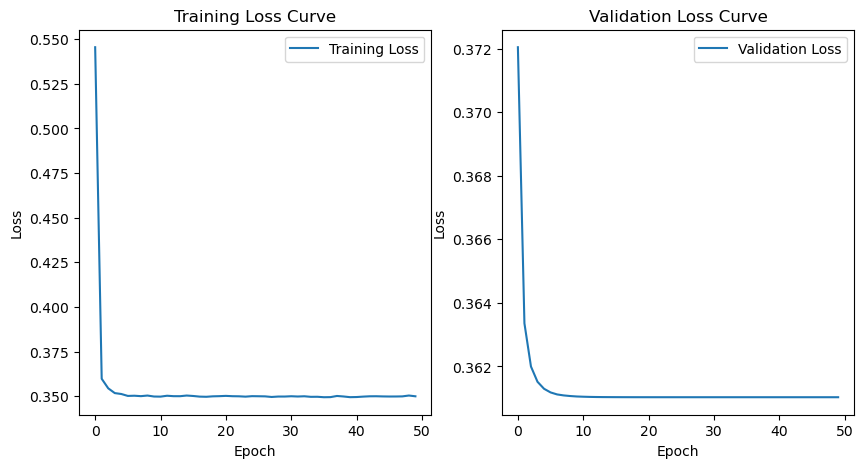

In [151]:
# Initialize model, criterion, and optimizer
model = PortfolioFCN(input_dim=len(indicators), output_dim=len(stocks))
criterion = SharpeRatioLoss(risk_free_rate=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Train the model
train_losses, val_losses = train_weights(train_loader, val_loader, model, criterion, optimizer, covariance_tensor, expected_returns_tensor, epochs=50)

# Plot loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Curve')
plt.legend()

# Save the figure as a PDF 
plt.savefig("lower_learning_rate_2.pdf")

In [152]:
# Test the model
weights = test_weights(test_loader, model, criterion, covariance_tensor, expected_returns_tensor)
print("Optimized Portfolio Weights:", weights)

print(weights.shape)

Test Loss: 0.3610
Optimized Portfolio Weights: [[0.0000000e+00 6.4646215e-15 0.0000000e+00 ... 6.0977666e-37
  0.0000000e+00 0.0000000e+00]
 [1.0274320e-41 2.4937734e-12 1.0274320e-41 ... 3.1420712e-30
  1.0274320e-41 1.0274320e-41]
 [0.0000000e+00 7.6298068e-15 0.0000000e+00 ... 9.3445649e-37
  0.0000000e+00 0.0000000e+00]
 ...
 [1.2069405e-35 1.2954923e-10 1.2069405e-35 ... 6.1631638e-26
  1.2069405e-35 1.2069405e-35]
 [0.0000000e+00 2.5417148e-14 0.0000000e+00 ... 2.3363462e-35
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 4.0451963e-14 0.0000000e+00 ... 8.3530009e-35
  0.0000000e+00 0.0000000e+00]]
(8976, 20)


In [153]:
# DataLoaders for batching
train_batch_size = 256
test_batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=train_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

  2%|▏         | 1/50 [00:00<00:26,  1.88it/s]

Epoch 1, Train Loss: 86.2429, Val Loss: 28.8509


  4%|▍         | 2/50 [00:01<00:26,  1.84it/s]

Epoch 2, Train Loss: 80.5381, Val Loss: 25.3061


  6%|▌         | 3/50 [00:01<00:25,  1.82it/s]

Epoch 3, Train Loss: 59.4731, Val Loss: 15.4063


  8%|▊         | 4/50 [00:02<00:25,  1.79it/s]

Epoch 4, Train Loss: 39.3029, Val Loss: 10.8262


 10%|█         | 5/50 [00:02<00:24,  1.85it/s]

Epoch 5, Train Loss: 33.2677, Val Loss: 9.5142


 12%|█▏        | 6/50 [00:03<00:23,  1.91it/s]

Epoch 6, Train Loss: 31.2689, Val Loss: 9.0010


 14%|█▍        | 7/50 [00:03<00:21,  1.96it/s]

Epoch 7, Train Loss: 29.9496, Val Loss: 8.7501


 16%|█▌        | 8/50 [00:04<00:21,  1.99it/s]

Epoch 8, Train Loss: 29.1357, Val Loss: 8.6081


 18%|█▊        | 9/50 [00:04<00:20,  2.01it/s]

Epoch 9, Train Loss: 28.5138, Val Loss: 8.5204


 20%|██        | 10/50 [00:05<00:19,  2.02it/s]

Epoch 10, Train Loss: 28.2890, Val Loss: 8.4613


 22%|██▏       | 11/50 [00:05<00:19,  2.03it/s]

Epoch 11, Train Loss: 27.9136, Val Loss: 8.4169


 24%|██▍       | 12/50 [00:06<00:18,  2.04it/s]

Epoch 12, Train Loss: 27.8126, Val Loss: 8.3843


 26%|██▌       | 13/50 [00:06<00:20,  1.80it/s]

Epoch 13, Train Loss: 27.5364, Val Loss: 8.3571


 28%|██▊       | 14/50 [00:07<00:20,  1.74it/s]

Epoch 14, Train Loss: 27.5496, Val Loss: 8.3371


 30%|███       | 15/50 [00:07<00:19,  1.79it/s]

Epoch 15, Train Loss: 27.5571, Val Loss: 8.3215


 32%|███▏      | 16/50 [00:08<00:18,  1.85it/s]

Epoch 16, Train Loss: 27.4482, Val Loss: 8.3085


 34%|███▍      | 17/50 [00:08<00:17,  1.91it/s]

Epoch 17, Train Loss: 27.3063, Val Loss: 8.2973


 36%|███▌      | 18/50 [00:09<00:16,  1.95it/s]

Epoch 18, Train Loss: 27.3113, Val Loss: 8.2880


 38%|███▊      | 19/50 [00:09<00:15,  1.95it/s]

Epoch 19, Train Loss: 27.2530, Val Loss: 8.2803


 40%|████      | 20/50 [00:10<00:15,  1.91it/s]

Epoch 20, Train Loss: 27.1875, Val Loss: 8.2737


 42%|████▏     | 21/50 [00:10<00:14,  1.95it/s]

Epoch 21, Train Loss: 27.1515, Val Loss: 8.2681


 44%|████▍     | 22/50 [00:11<00:14,  1.92it/s]

Epoch 22, Train Loss: 27.0781, Val Loss: 8.2630


 46%|████▌     | 23/50 [00:12<00:13,  1.94it/s]

Epoch 23, Train Loss: 27.1277, Val Loss: 8.2590


 48%|████▊     | 24/50 [00:12<00:14,  1.86it/s]

Epoch 24, Train Loss: 27.0211, Val Loss: 8.2550


 50%|█████     | 25/50 [00:13<00:12,  1.92it/s]

Epoch 25, Train Loss: 27.1156, Val Loss: 8.2520


 52%|█████▏    | 26/50 [00:13<00:12,  1.97it/s]

Epoch 26, Train Loss: 26.9210, Val Loss: 8.2489


 54%|█████▍    | 27/50 [00:14<00:11,  2.01it/s]

Epoch 27, Train Loss: 27.0877, Val Loss: 8.2465


 56%|█████▌    | 28/50 [00:14<00:10,  2.02it/s]

Epoch 28, Train Loss: 27.0280, Val Loss: 8.2441


 58%|█████▊    | 29/50 [00:15<00:10,  2.05it/s]

Epoch 29, Train Loss: 27.0481, Val Loss: 8.2421


 60%|██████    | 30/50 [00:15<00:09,  2.05it/s]

Epoch 30, Train Loss: 27.0709, Val Loss: 8.2404


 62%|██████▏   | 31/50 [00:15<00:09,  2.07it/s]

Epoch 31, Train Loss: 26.9814, Val Loss: 8.2388


 64%|██████▍   | 32/50 [00:16<00:08,  2.03it/s]

Epoch 32, Train Loss: 26.9880, Val Loss: 8.2373


 66%|██████▌   | 33/50 [00:16<00:08,  2.05it/s]

Epoch 33, Train Loss: 27.0551, Val Loss: 8.2360


 68%|██████▊   | 34/50 [00:17<00:07,  2.06it/s]

Epoch 34, Train Loss: 26.9563, Val Loss: 8.2347


 70%|███████   | 35/50 [00:17<00:07,  2.08it/s]

Epoch 35, Train Loss: 27.0084, Val Loss: 8.2335


 72%|███████▏  | 36/50 [00:18<00:06,  2.08it/s]

Epoch 36, Train Loss: 26.9540, Val Loss: 8.2325


 74%|███████▍  | 37/50 [00:18<00:06,  2.09it/s]

Epoch 37, Train Loss: 26.8984, Val Loss: 8.2315


 76%|███████▌  | 38/50 [00:19<00:05,  2.11it/s]

Epoch 38, Train Loss: 27.0071, Val Loss: 8.2308


 78%|███████▊  | 39/50 [00:19<00:05,  2.10it/s]

Epoch 39, Train Loss: 26.9403, Val Loss: 8.2302


 80%|████████  | 40/50 [00:20<00:04,  2.11it/s]

Epoch 40, Train Loss: 26.8868, Val Loss: 8.2294


 82%|████████▏ | 41/50 [00:20<00:04,  1.87it/s]

Epoch 41, Train Loss: 26.9564, Val Loss: 8.2288


 84%|████████▍ | 42/50 [00:21<00:04,  1.89it/s]

Epoch 42, Train Loss: 26.9447, Val Loss: 8.2283


 86%|████████▌ | 43/50 [00:21<00:03,  1.95it/s]

Epoch 43, Train Loss: 26.8901, Val Loss: 8.2278


 88%|████████▊ | 44/50 [00:22<00:03,  1.99it/s]

Epoch 44, Train Loss: 26.8841, Val Loss: 8.2273


 90%|█████████ | 45/50 [00:22<00:02,  2.02it/s]

Epoch 45, Train Loss: 26.8848, Val Loss: 8.2269


 92%|█████████▏| 46/50 [00:23<00:01,  2.03it/s]

Epoch 46, Train Loss: 26.8735, Val Loss: 8.2264


 94%|█████████▍| 47/50 [00:23<00:01,  2.05it/s]

Epoch 47, Train Loss: 27.0081, Val Loss: 8.2261


 96%|█████████▌| 48/50 [00:24<00:00,  2.07it/s]

Epoch 48, Train Loss: 26.8898, Val Loss: 8.2258


 98%|█████████▊| 49/50 [00:24<00:00,  2.06it/s]

Epoch 49, Train Loss: 26.8044, Val Loss: 8.2255


100%|██████████| 50/50 [00:25<00:00,  1.98it/s]

Epoch 50, Train Loss: 26.8945, Val Loss: 8.2252


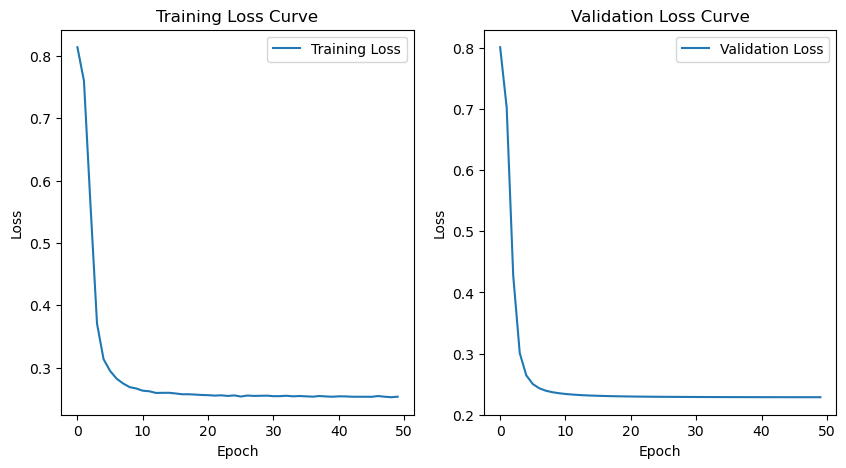

In [154]:
# Initialize model, criterion, and optimizer
model = PortfolioFCN(input_dim=len(indicators), output_dim=len(stocks))
criterion = SharpeRatioLoss(risk_free_rate=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Train the model
train_losses, val_losses = train_weights(train_loader, val_loader, model, criterion, optimizer, covariance_tensor, expected_returns_tensor, epochs=50)

# Plot loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Curve')
plt.legend()

# Save the figure as a PDF 
plt.savefig("large_batch_size_1.pdf")

In [155]:
# Test the model
weights = test_weights(test_loader, model, criterion, covariance_tensor, expected_returns_tensor)
print("Optimized Portfolio Weights:", weights)

print(weights.shape)

Test Loss: 0.2285
Optimized Portfolio Weights: [[3.3044501e-13 9.9999285e-01 3.3044501e-13 ... 4.5429656e-09
  3.3044501e-13 3.3044501e-13]
 [1.8213368e-10 9.9990547e-01 1.8213368e-10 ... 3.0597229e-07
  1.8213368e-10 1.8213368e-10]
 [2.4481922e-13 9.9999368e-01 2.4481922e-13 ... 3.6930277e-09
  2.4481922e-13 2.4481922e-13]
 ...
 [5.6142060e-09 9.9960452e-01 5.6142060e-09 ... 2.9511737e-06
  5.6142060e-09 5.6142060e-09]
 [1.4579885e-12 9.9998677e-01 1.4579885e-12 ... 1.2303446e-08
  1.4579885e-12 1.4579885e-12]
 [8.6022444e-13 9.9998927e-01 8.6022444e-13 ... 8.8690486e-09
  8.6022444e-13 8.6022444e-13]]
(8976, 20)


In [156]:
# DataLoaders for batching
train_batch_size = 512
test_batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=train_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

  2%|▏         | 1/50 [00:00<00:25,  1.93it/s]

Epoch 1, Train Loss: 43.2099, Val Loss: 14.5851


  4%|▍         | 2/50 [00:00<00:22,  2.12it/s]

Epoch 2, Train Loss: 42.4299, Val Loss: 14.2325


  6%|▌         | 3/50 [00:01<00:21,  2.15it/s]

Epoch 3, Train Loss: 40.4917, Val Loss: 13.3467


  8%|▊         | 4/50 [00:01<00:22,  2.07it/s]

Epoch 4, Train Loss: 36.3838, Val Loss: 11.4790


 10%|█         | 5/50 [00:02<00:21,  2.12it/s]

Epoch 5, Train Loss: 29.4627, Val Loss: 8.8198


 12%|█▏        | 6/50 [00:02<00:20,  2.16it/s]

Epoch 6, Train Loss: 23.3956, Val Loss: 6.9249


 14%|█▍        | 7/50 [00:03<00:20,  2.15it/s]

Epoch 7, Train Loss: 19.8356, Val Loss: 5.8848


 16%|█▌        | 8/50 [00:03<00:19,  2.19it/s]

Epoch 8, Train Loss: 18.0282, Val Loss: 5.3078


 18%|█▊        | 9/50 [00:04<00:19,  2.16it/s]

Epoch 9, Train Loss: 17.1564, Val Loss: 4.9709


 20%|██        | 10/50 [00:04<00:18,  2.20it/s]

Epoch 10, Train Loss: 16.5389, Val Loss: 4.7583


 22%|██▏       | 11/50 [00:05<00:17,  2.19it/s]

Epoch 11, Train Loss: 16.0939, Val Loss: 4.6178


 24%|██▍       | 12/50 [00:05<00:17,  2.16it/s]

Epoch 12, Train Loss: 15.7581, Val Loss: 4.5183


 26%|██▌       | 13/50 [00:06<00:16,  2.20it/s]

Epoch 13, Train Loss: 15.2762, Val Loss: 4.4455


 28%|██▊       | 14/50 [00:06<00:16,  2.23it/s]

Epoch 14, Train Loss: 14.8426, Val Loss: 4.3907


 30%|███       | 15/50 [00:07<00:17,  1.95it/s]

Epoch 15, Train Loss: 14.5554, Val Loss: 4.3485


 32%|███▏      | 16/50 [00:07<00:16,  2.04it/s]

Epoch 16, Train Loss: 14.2664, Val Loss: 4.3165


 34%|███▍      | 17/50 [00:07<00:15,  2.12it/s]

Epoch 17, Train Loss: 14.0755, Val Loss: 4.2913


 36%|███▌      | 18/50 [00:08<00:14,  2.16it/s]

Epoch 18, Train Loss: 13.8532, Val Loss: 4.2707


 38%|███▊      | 19/50 [00:08<00:14,  2.15it/s]

Epoch 19, Train Loss: 13.7298, Val Loss: 4.2534


 40%|████      | 20/50 [00:09<00:13,  2.20it/s]

Epoch 20, Train Loss: 13.6801, Val Loss: 4.2388


 42%|████▏     | 21/50 [00:09<00:13,  2.20it/s]

Epoch 21, Train Loss: 13.5982, Val Loss: 4.2262


 44%|████▍     | 22/50 [00:10<00:12,  2.23it/s]

Epoch 22, Train Loss: 13.4567, Val Loss: 4.2149


 46%|████▌     | 23/50 [00:10<00:12,  2.24it/s]

Epoch 23, Train Loss: 13.4948, Val Loss: 4.2055


 48%|████▊     | 24/50 [00:11<00:11,  2.24it/s]

Epoch 24, Train Loss: 13.4532, Val Loss: 4.1970


 50%|█████     | 25/50 [00:11<00:11,  2.26it/s]

Epoch 25, Train Loss: 13.3689, Val Loss: 4.1894


 52%|█████▏    | 26/50 [00:11<00:10,  2.28it/s]

Epoch 26, Train Loss: 13.3155, Val Loss: 4.1824


 54%|█████▍    | 27/50 [00:12<00:10,  2.28it/s]

Epoch 27, Train Loss: 13.2832, Val Loss: 4.1760


 56%|█████▌    | 28/50 [00:12<00:09,  2.30it/s]

Epoch 28, Train Loss: 13.2900, Val Loss: 4.1705


 58%|█████▊    | 29/50 [00:13<00:10,  2.09it/s]

Epoch 29, Train Loss: 13.2931, Val Loss: 4.1653


 60%|██████    | 30/50 [00:13<00:09,  2.14it/s]

Epoch 30, Train Loss: 13.2342, Val Loss: 4.1609


 62%|██████▏   | 31/50 [00:14<00:09,  2.02it/s]

Epoch 31, Train Loss: 13.2176, Val Loss: 4.1570


 64%|██████▍   | 32/50 [00:14<00:08,  2.09it/s]

Epoch 32, Train Loss: 13.2128, Val Loss: 4.1534


 66%|██████▌   | 33/50 [00:15<00:07,  2.15it/s]

Epoch 33, Train Loss: 13.2045, Val Loss: 4.1502


 68%|██████▊   | 34/50 [00:15<00:07,  2.19it/s]

Epoch 34, Train Loss: 13.1882, Val Loss: 4.1473


 70%|███████   | 35/50 [00:16<00:06,  2.22it/s]

Epoch 35, Train Loss: 13.2131, Val Loss: 4.1446


 72%|███████▏  | 36/50 [00:16<00:06,  2.25it/s]

Epoch 36, Train Loss: 13.1538, Val Loss: 4.1422


 74%|███████▍  | 37/50 [00:17<00:05,  2.25it/s]

Epoch 37, Train Loss: 13.2046, Val Loss: 4.1402


 76%|███████▌  | 38/50 [00:17<00:05,  2.26it/s]

Epoch 38, Train Loss: 13.1128, Val Loss: 4.1382


 78%|███████▊  | 39/50 [00:17<00:04,  2.22it/s]

Epoch 39, Train Loss: 13.1185, Val Loss: 4.1364


 80%|████████  | 40/50 [00:18<00:04,  2.23it/s]

Epoch 40, Train Loss: 13.1395, Val Loss: 4.1348


 82%|████████▏ | 41/50 [00:18<00:04,  2.25it/s]

Epoch 41, Train Loss: 13.1807, Val Loss: 4.1333


 84%|████████▍ | 42/50 [00:19<00:03,  2.25it/s]

Epoch 42, Train Loss: 13.1723, Val Loss: 4.1319


 86%|████████▌ | 43/50 [00:19<00:03,  2.22it/s]

Epoch 43, Train Loss: 13.1218, Val Loss: 4.1306


 88%|████████▊ | 44/50 [00:20<00:02,  2.17it/s]

Epoch 44, Train Loss: 13.1063, Val Loss: 4.1295


 90%|█████████ | 45/50 [00:20<00:02,  2.16it/s]

Epoch 45, Train Loss: 13.1051, Val Loss: 4.1284


 92%|█████████▏| 46/50 [00:21<00:01,  2.15it/s]

Epoch 46, Train Loss: 13.0913, Val Loss: 4.1274


 94%|█████████▍| 47/50 [00:21<00:01,  2.12it/s]

Epoch 47, Train Loss: 13.1254, Val Loss: 4.1264


 96%|█████████▌| 48/50 [00:22<00:00,  2.10it/s]

Epoch 48, Train Loss: 13.0864, Val Loss: 4.1256


 98%|█████████▊| 49/50 [00:22<00:00,  2.08it/s]

Epoch 49, Train Loss: 13.1062, Val Loss: 4.1248


100%|██████████| 50/50 [00:23<00:00,  2.17it/s]

Epoch 50, Train Loss: 13.0692, Val Loss: 4.1241


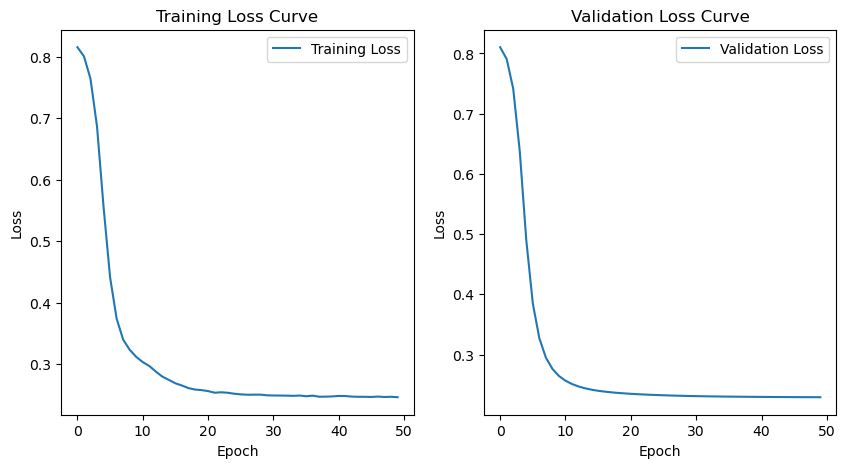

In [157]:
# Initialize model, criterion, and optimizer
model = PortfolioFCN(input_dim=len(indicators), output_dim=len(stocks))
criterion = SharpeRatioLoss(risk_free_rate=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Train the model
train_losses, val_losses = train_weights(train_loader, val_loader, model, criterion, optimizer, covariance_tensor, expected_returns_tensor, epochs=50)

# Plot loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Curve')
plt.legend()

# Save the figure as a PDF 
plt.savefig("large_batch_size_2.pdf")

In [158]:
# Test the model
weights = test_weights(test_loader, model, criterion, covariance_tensor, expected_returns_tensor)
print("Optimized Portfolio Weights:", weights)

print(weights.shape)

Test Loss: 0.2291
Optimized Portfolio Weights: [[7.0690307e-09 9.9986017e-01 7.0690307e-09 ... 7.0690307e-09
  7.0690307e-09 7.0690307e-09]
 [3.8257451e-07 9.9904484e-01 3.8257451e-07 ... 3.8257451e-07
  3.8257451e-07 3.8257451e-07]
 [7.3925137e-09 9.9985635e-01 7.3925137e-09 ... 7.3925137e-09
  7.3925137e-09 7.3925137e-09]
 ...
 [4.5079328e-06 9.9703419e-01 4.5079328e-06 ... 4.5079328e-06
  4.5079328e-06 4.5079328e-06]
 [3.0789909e-08 9.9971670e-01 3.0789909e-08 ... 3.0789909e-08
  3.0789909e-08 3.0789909e-08]
 [5.4070931e-08 9.9962640e-01 5.4070931e-08 ... 5.4070931e-08
  5.4070931e-08 5.4070931e-08]]
(8976, 20)


  2%|▏         | 1/50 [00:00<00:22,  2.23it/s]

Epoch 1, Train Loss: 22.0752, Val Loss: 7.3355


  4%|▍         | 2/50 [00:00<00:21,  2.19it/s]

Epoch 2, Train Loss: 21.9279, Val Loss: 7.2876


  6%|▌         | 3/50 [00:01<00:21,  2.22it/s]

Epoch 3, Train Loss: 21.7570, Val Loss: 7.2295


  8%|▊         | 4/50 [00:01<00:20,  2.27it/s]

Epoch 4, Train Loss: 21.5411, Val Loss: 7.1521


 10%|█         | 5/50 [00:02<00:23,  1.94it/s]

Epoch 5, Train Loss: 21.2317, Val Loss: 7.0392


 12%|█▏        | 6/50 [00:02<00:21,  2.06it/s]

Epoch 6, Train Loss: 20.7454, Val Loss: 6.8615


 14%|█▍        | 7/50 [00:03<00:20,  2.10it/s]

Epoch 7, Train Loss: 20.0047, Val Loss: 6.5795


 16%|█▌        | 8/50 [00:03<00:19,  2.19it/s]

Epoch 8, Train Loss: 18.8758, Val Loss: 6.1605


 18%|█▊        | 9/50 [00:04<00:18,  2.20it/s]

Epoch 9, Train Loss: 17.3448, Val Loss: 5.5828


 20%|██        | 10/50 [00:04<00:17,  2.23it/s]

Epoch 10, Train Loss: 15.4920, Val Loss: 4.9132


 22%|██▏       | 11/50 [00:05<00:17,  2.27it/s]

Epoch 11, Train Loss: 13.6737, Val Loss: 4.2875


 24%|██▍       | 12/50 [00:05<00:16,  2.30it/s]

Epoch 12, Train Loss: 12.1409, Val Loss: 3.7813


 26%|██▌       | 13/50 [00:06<00:17,  2.12it/s]

Epoch 13, Train Loss: 11.0311, Val Loss: 3.3986


 28%|██▊       | 14/50 [00:06<00:16,  2.19it/s]

Epoch 14, Train Loss: 10.1982, Val Loss: 3.1164


 30%|███       | 15/50 [00:06<00:15,  2.24it/s]

Epoch 15, Train Loss: 9.5865, Val Loss: 2.9079


 32%|███▏      | 16/50 [00:07<00:14,  2.27it/s]

Epoch 16, Train Loss: 9.1429, Val Loss: 2.7521


 34%|███▍      | 17/50 [00:07<00:14,  2.25it/s]

Epoch 17, Train Loss: 8.7755, Val Loss: 2.6335


 36%|███▌      | 18/50 [00:08<00:13,  2.29it/s]

Epoch 18, Train Loss: 8.4969, Val Loss: 2.5418


 38%|███▊      | 19/50 [00:08<00:13,  2.31it/s]

Epoch 19, Train Loss: 8.2377, Val Loss: 2.4702


 40%|████      | 20/50 [00:09<00:13,  2.30it/s]

Epoch 20, Train Loss: 8.0869, Val Loss: 2.4130


 42%|████▏     | 21/50 [00:09<00:13,  2.14it/s]

Epoch 21, Train Loss: 7.8978, Val Loss: 2.3673


 44%|████▍     | 22/50 [00:09<00:12,  2.21it/s]

Epoch 22, Train Loss: 7.7737, Val Loss: 2.3298


 46%|████▌     | 23/50 [00:10<00:11,  2.25it/s]

Epoch 23, Train Loss: 7.6463, Val Loss: 2.2992


 48%|████▊     | 24/50 [00:10<00:11,  2.29it/s]

Epoch 24, Train Loss: 7.5335, Val Loss: 2.2736


 50%|█████     | 25/50 [00:11<00:10,  2.31it/s]

Epoch 25, Train Loss: 7.4513, Val Loss: 2.2519


 52%|█████▏    | 26/50 [00:11<00:10,  2.33it/s]

Epoch 26, Train Loss: 7.4058, Val Loss: 2.2338


 54%|█████▍    | 27/50 [00:12<00:10,  2.29it/s]

Epoch 27, Train Loss: 7.2872, Val Loss: 2.2178


 56%|█████▌    | 28/50 [00:13<00:13,  1.65it/s]

Epoch 28, Train Loss: 7.2542, Val Loss: 2.2041


 58%|█████▊    | 29/50 [00:13<00:11,  1.76it/s]

Epoch 29, Train Loss: 7.1630, Val Loss: 2.1919


 60%|██████    | 30/50 [00:14<00:10,  1.87it/s]

Epoch 30, Train Loss: 7.1015, Val Loss: 2.1811


 62%|██████▏   | 31/50 [00:14<00:09,  1.96it/s]

Epoch 31, Train Loss: 7.0931, Val Loss: 2.1715


 64%|██████▍   | 32/50 [00:14<00:08,  2.02it/s]

Epoch 32, Train Loss: 7.0922, Val Loss: 2.1632


 66%|██████▌   | 33/50 [00:15<00:08,  2.11it/s]

Epoch 33, Train Loss: 7.0368, Val Loss: 2.1557


 68%|██████▊   | 34/50 [00:15<00:07,  2.18it/s]

Epoch 34, Train Loss: 7.0021, Val Loss: 2.1488


 70%|███████   | 35/50 [00:16<00:06,  2.24it/s]

Epoch 35, Train Loss: 6.9732, Val Loss: 2.1427


 72%|███████▏  | 36/50 [00:16<00:06,  2.08it/s]

Epoch 36, Train Loss: 6.9543, Val Loss: 2.1369


 74%|███████▍  | 37/50 [00:17<00:06,  1.94it/s]

Epoch 37, Train Loss: 6.9407, Val Loss: 2.1319


 76%|███████▌  | 38/50 [00:17<00:05,  2.05it/s]

Epoch 38, Train Loss: 6.9011, Val Loss: 2.1273


 78%|███████▊  | 39/50 [00:18<00:05,  2.13it/s]

Epoch 39, Train Loss: 6.8819, Val Loss: 2.1229


 80%|████████  | 40/50 [00:18<00:04,  2.20it/s]

Epoch 40, Train Loss: 6.8796, Val Loss: 2.1188


 82%|████████▏ | 41/50 [00:19<00:04,  2.24it/s]

Epoch 41, Train Loss: 6.8648, Val Loss: 2.1150


 84%|████████▍ | 42/50 [00:19<00:03,  2.25it/s]

Epoch 42, Train Loss: 6.8658, Val Loss: 2.1116


 86%|████████▌ | 43/50 [00:20<00:03,  2.08it/s]

Epoch 43, Train Loss: 6.8461, Val Loss: 2.1086


 88%|████████▊ | 44/50 [00:20<00:02,  2.10it/s]

Epoch 44, Train Loss: 6.8278, Val Loss: 2.1058


 90%|█████████ | 45/50 [00:21<00:02,  2.09it/s]

Epoch 45, Train Loss: 6.8276, Val Loss: 2.1032


 92%|█████████▏| 46/50 [00:21<00:01,  2.14it/s]

Epoch 46, Train Loss: 6.8187, Val Loss: 2.1008


 94%|█████████▍| 47/50 [00:21<00:01,  2.10it/s]

Epoch 47, Train Loss: 6.7953, Val Loss: 2.0984


 96%|█████████▌| 48/50 [00:22<00:00,  2.13it/s]

Epoch 48, Train Loss: 6.8116, Val Loss: 2.0964


 98%|█████████▊| 49/50 [00:22<00:00,  2.19it/s]

Epoch 49, Train Loss: 6.7987, Val Loss: 2.0944


100%|██████████| 50/50 [00:23<00:00,  2.15it/s]

Epoch 50, Train Loss: 6.7828, Val Loss: 2.0925


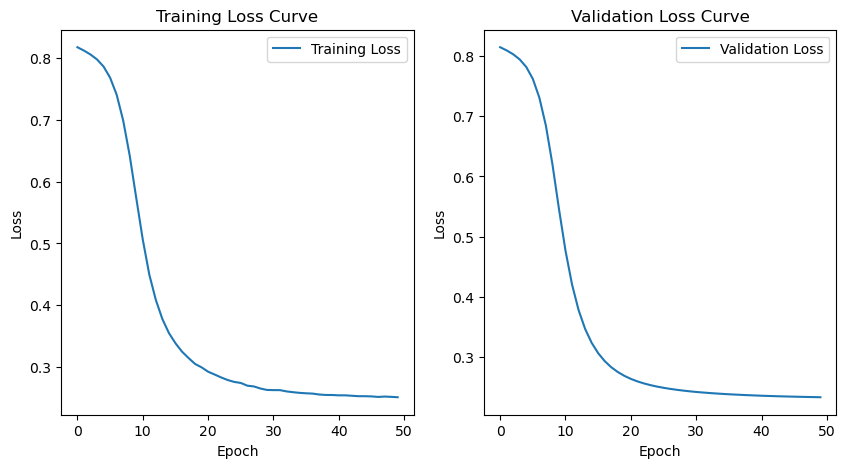

In [163]:
# DataLoaders for batching
train_batch_size = 1024
test_batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=train_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

# Initialize model, criterion, and optimizer
model = PortfolioFCN(input_dim=len(indicators), output_dim=len(stocks))
criterion = SharpeRatioLoss(risk_free_rate=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Train the model
train_losses, val_losses = train_weights(train_loader, val_loader, model, criterion, optimizer, covariance_tensor, expected_returns_tensor, epochs=50)

# Plot loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Curve')
plt.legend()

# Save the figure as a PDF 
plt.savefig("large_batch_size_4.pdf")

In [164]:
# Test the model
weights = test_weights(test_loader, model, criterion, covariance_tensor, expected_returns_tensor)
print("Optimized Portfolio Weights:", weights)

print(weights.shape)

Test Loss: 0.2326
Optimized Portfolio Weights: [[1.4118993e-06 9.9848831e-01 1.4118993e-06 ... 1.4118993e-06
  1.4118993e-06 1.4118993e-06]
 [1.0368502e-05 9.9565601e-01 1.0368502e-05 ... 1.0368502e-05
  1.0368502e-05 1.0368502e-05]
 [1.3975628e-06 9.9852091e-01 1.3975628e-06 ... 1.3975628e-06
  1.3975628e-06 1.3975628e-06]
 ...
 [2.7017380e-04 9.7680503e-01 2.7017380e-04 ... 2.7017380e-04
  2.7017380e-04 2.7017380e-04]
 [1.6740391e-06 9.9825901e-01 1.6740391e-06 ... 1.6740391e-06
  1.6740391e-06 1.6740391e-06]
 [1.0087523e-06 9.9861884e-01 1.0087523e-06 ... 1.0087523e-06
  1.0087523e-06 1.0087523e-06]]
(8976, 20)


  1%|          | 1/100 [00:00<01:08,  1.45it/s]

Epoch 1, Train Loss: 22.0695, Val Loss: 7.3330


  2%|▏         | 2/100 [00:01<00:54,  1.81it/s]

Epoch 2, Train Loss: 21.9223, Val Loss: 7.2833


  3%|▎         | 3/100 [00:01<00:49,  1.95it/s]

Epoch 3, Train Loss: 21.7363, Val Loss: 7.2190


  4%|▍         | 4/100 [00:02<00:45,  2.09it/s]

Epoch 4, Train Loss: 21.4815, Val Loss: 7.1258


  5%|▌         | 5/100 [00:02<00:43,  2.19it/s]

Epoch 5, Train Loss: 21.0927, Val Loss: 6.9845


  6%|▌         | 6/100 [00:02<00:41,  2.24it/s]

Epoch 6, Train Loss: 20.5169, Val Loss: 6.7758


  7%|▋         | 7/100 [00:03<00:40,  2.28it/s]

Epoch 7, Train Loss: 19.7362, Val Loss: 6.4905


  8%|▊         | 8/100 [00:03<00:44,  2.04it/s]

Epoch 8, Train Loss: 18.6845, Val Loss: 6.1059


  9%|▉         | 9/100 [00:04<00:42,  2.13it/s]

Epoch 9, Train Loss: 17.2890, Val Loss: 5.5869


 10%|█         | 10/100 [00:04<00:41,  2.16it/s]

Epoch 10, Train Loss: 15.5392, Val Loss: 4.9572


 11%|█         | 11/100 [00:05<00:40,  2.21it/s]

Epoch 11, Train Loss: 13.7359, Val Loss: 4.3270


 12%|█▏        | 12/100 [00:05<00:39,  2.25it/s]

Epoch 12, Train Loss: 12.2081, Val Loss: 3.7987


 13%|█▎        | 13/100 [00:06<00:37,  2.29it/s]

Epoch 13, Train Loss: 11.0110, Val Loss: 3.4004


 14%|█▍        | 14/100 [00:06<00:37,  2.32it/s]

Epoch 14, Train Loss: 10.1793, Val Loss: 3.1095


 15%|█▌        | 15/100 [00:07<00:39,  2.14it/s]

Epoch 15, Train Loss: 9.6082, Val Loss: 2.8975


 16%|█▌        | 16/100 [00:07<00:38,  2.20it/s]

Epoch 16, Train Loss: 9.2310, Val Loss: 2.7422


 17%|█▋        | 17/100 [00:07<00:36,  2.25it/s]

Epoch 17, Train Loss: 8.9345, Val Loss: 2.6258


 18%|█▊        | 18/100 [00:08<00:36,  2.24it/s]

Epoch 18, Train Loss: 8.6611, Val Loss: 2.5361


 19%|█▉        | 19/100 [00:08<00:35,  2.28it/s]

Epoch 19, Train Loss: 8.4537, Val Loss: 2.4660


 20%|██        | 20/100 [00:09<00:34,  2.30it/s]

Epoch 20, Train Loss: 8.2816, Val Loss: 2.4103


 21%|██        | 21/100 [00:09<00:34,  2.32it/s]

Epoch 21, Train Loss: 8.1652, Val Loss: 2.3653


 22%|██▏       | 22/100 [00:10<00:33,  2.34it/s]

Epoch 22, Train Loss: 8.0530, Val Loss: 2.3288


 23%|██▎       | 23/100 [00:10<00:36,  2.14it/s]

Epoch 23, Train Loss: 7.9782, Val Loss: 2.2982


 24%|██▍       | 24/100 [00:11<00:35,  2.15it/s]

Epoch 24, Train Loss: 7.8743, Val Loss: 2.2728


 25%|██▌       | 25/100 [00:11<00:34,  2.17it/s]

Epoch 25, Train Loss: 7.7912, Val Loss: 2.2510


 26%|██▌       | 26/100 [00:11<00:34,  2.17it/s]

Epoch 26, Train Loss: 7.7433, Val Loss: 2.2324


 27%|██▋       | 27/100 [00:12<00:33,  2.19it/s]

Epoch 27, Train Loss: 7.6274, Val Loss: 2.2159


 28%|██▊       | 28/100 [00:12<00:32,  2.21it/s]

Epoch 28, Train Loss: 7.5410, Val Loss: 2.2017


 29%|██▉       | 29/100 [00:13<00:31,  2.25it/s]

Epoch 29, Train Loss: 7.4531, Val Loss: 2.1894


 30%|███       | 30/100 [00:13<00:33,  2.07it/s]

Epoch 30, Train Loss: 7.3376, Val Loss: 2.1787


 31%|███       | 31/100 [00:14<00:32,  2.15it/s]

Epoch 31, Train Loss: 7.2982, Val Loss: 2.1696


 32%|███▏      | 32/100 [00:14<00:30,  2.21it/s]

Epoch 32, Train Loss: 7.2051, Val Loss: 2.1616


 33%|███▎      | 33/100 [00:15<00:29,  2.25it/s]

Epoch 33, Train Loss: 7.1370, Val Loss: 2.1547


 34%|███▍      | 34/100 [00:15<00:29,  2.26it/s]

Epoch 34, Train Loss: 7.0798, Val Loss: 2.1485


 35%|███▌      | 35/100 [00:15<00:28,  2.29it/s]

Epoch 35, Train Loss: 7.0481, Val Loss: 2.1429


 36%|███▌      | 36/100 [00:16<00:28,  2.27it/s]

Epoch 36, Train Loss: 6.9861, Val Loss: 2.1378


 37%|███▋      | 37/100 [00:16<00:30,  2.06it/s]

Epoch 37, Train Loss: 6.9640, Val Loss: 2.1331


 38%|███▊      | 38/100 [00:17<00:29,  2.11it/s]

Epoch 38, Train Loss: 6.9479, Val Loss: 2.1288


 39%|███▉      | 39/100 [00:17<00:27,  2.18it/s]

Epoch 39, Train Loss: 6.9083, Val Loss: 2.1248


 40%|████      | 40/100 [00:18<00:26,  2.24it/s]

Epoch 40, Train Loss: 6.9207, Val Loss: 2.1212


 41%|████      | 41/100 [00:18<00:25,  2.27it/s]

Epoch 41, Train Loss: 6.8740, Val Loss: 2.1178


 42%|████▏     | 42/100 [00:19<00:25,  2.30it/s]

Epoch 42, Train Loss: 6.8748, Val Loss: 2.1147


 43%|████▎     | 43/100 [00:19<00:25,  2.28it/s]

Epoch 43, Train Loss: 6.8536, Val Loss: 2.1117


 44%|████▍     | 44/100 [00:20<00:24,  2.26it/s]

Epoch 44, Train Loss: 6.8310, Val Loss: 2.1088


 45%|████▌     | 45/100 [00:20<00:26,  2.07it/s]

Epoch 45, Train Loss: 6.8374, Val Loss: 2.1062


 46%|████▌     | 46/100 [00:21<00:26,  2.04it/s]

Epoch 46, Train Loss: 6.8176, Val Loss: 2.1038


 47%|████▋     | 47/100 [00:21<00:25,  2.12it/s]

Epoch 47, Train Loss: 6.7958, Val Loss: 2.1015


 48%|████▊     | 48/100 [00:21<00:23,  2.18it/s]

Epoch 48, Train Loss: 6.7831, Val Loss: 2.0992


 49%|████▉     | 49/100 [00:22<00:22,  2.23it/s]

Epoch 49, Train Loss: 6.7746, Val Loss: 2.0971


 50%|█████     | 50/100 [00:22<00:22,  2.27it/s]

Epoch 50, Train Loss: 6.7939, Val Loss: 2.0952


 51%|█████     | 51/100 [00:23<00:21,  2.30it/s]

Epoch 51, Train Loss: 6.7693, Val Loss: 2.0934


 52%|█████▏    | 52/100 [00:23<00:22,  2.13it/s]

Epoch 52, Train Loss: 6.7677, Val Loss: 2.0917


 53%|█████▎    | 53/100 [00:24<00:21,  2.20it/s]

Epoch 53, Train Loss: 6.7591, Val Loss: 2.0901


 54%|█████▍    | 54/100 [00:24<00:20,  2.22it/s]

Epoch 54, Train Loss: 6.7477, Val Loss: 2.0885


 55%|█████▌    | 55/100 [00:25<00:19,  2.26it/s]

Epoch 55, Train Loss: 6.7400, Val Loss: 2.0871


 56%|█████▌    | 56/100 [00:25<00:19,  2.24it/s]

Epoch 56, Train Loss: 6.7301, Val Loss: 2.0858


 57%|█████▋    | 57/100 [00:25<00:18,  2.29it/s]

Epoch 57, Train Loss: 6.7275, Val Loss: 2.0845


 58%|█████▊    | 58/100 [00:26<00:18,  2.31it/s]

Epoch 58, Train Loss: 6.7253, Val Loss: 2.0833


 59%|█████▉    | 59/100 [00:26<00:18,  2.17it/s]

Epoch 59, Train Loss: 6.7155, Val Loss: 2.0822


 60%|██████    | 60/100 [00:27<00:19,  2.03it/s]

Epoch 60, Train Loss: 6.7157, Val Loss: 2.0810


 61%|██████    | 61/100 [00:27<00:18,  2.10it/s]

Epoch 61, Train Loss: 6.6890, Val Loss: 2.0800


 62%|██████▏   | 62/100 [00:28<00:17,  2.18it/s]

Epoch 62, Train Loss: 6.6750, Val Loss: 2.0790


 63%|██████▎   | 63/100 [00:28<00:16,  2.23it/s]

Epoch 63, Train Loss: 6.6956, Val Loss: 2.0781


 64%|██████▍   | 64/100 [00:29<00:15,  2.25it/s]

Epoch 64, Train Loss: 6.6975, Val Loss: 2.0773


 65%|██████▌   | 65/100 [00:29<00:15,  2.29it/s]

Epoch 65, Train Loss: 6.6923, Val Loss: 2.0765


 66%|██████▌   | 66/100 [00:30<00:15,  2.23it/s]

Epoch 66, Train Loss: 6.6974, Val Loss: 2.0757


 67%|██████▋   | 67/100 [00:30<00:15,  2.06it/s]

Epoch 67, Train Loss: 6.6998, Val Loss: 2.0750


 68%|██████▊   | 68/100 [00:31<00:15,  2.09it/s]

Epoch 68, Train Loss: 6.6696, Val Loss: 2.0743


 69%|██████▉   | 69/100 [00:31<00:14,  2.12it/s]

Epoch 69, Train Loss: 6.6751, Val Loss: 2.0737


 70%|███████   | 70/100 [00:32<00:14,  2.12it/s]

Epoch 70, Train Loss: 6.6586, Val Loss: 2.0730


 71%|███████   | 71/100 [00:32<00:13,  2.15it/s]

Epoch 71, Train Loss: 6.6673, Val Loss: 2.0724


 72%|███████▏  | 72/100 [00:32<00:12,  2.15it/s]

Epoch 72, Train Loss: 6.6484, Val Loss: 2.0719


 73%|███████▎  | 73/100 [00:33<00:12,  2.21it/s]

Epoch 73, Train Loss: 6.6457, Val Loss: 2.0713


 74%|███████▍  | 74/100 [00:33<00:11,  2.23it/s]

Epoch 74, Train Loss: 6.6546, Val Loss: 2.0708


 75%|███████▌  | 75/100 [00:34<00:12,  2.07it/s]

Epoch 75, Train Loss: 6.6512, Val Loss: 2.0703


 76%|███████▌  | 76/100 [00:34<00:11,  2.15it/s]

Epoch 76, Train Loss: 6.6426, Val Loss: 2.0698


 77%|███████▋  | 77/100 [00:35<00:10,  2.20it/s]

Epoch 77, Train Loss: 6.6623, Val Loss: 2.0693


 78%|███████▊  | 78/100 [00:35<00:09,  2.21it/s]

Epoch 78, Train Loss: 6.6283, Val Loss: 2.0689


 79%|███████▉  | 79/100 [00:36<00:09,  2.24it/s]

Epoch 79, Train Loss: 6.6502, Val Loss: 2.0685


 80%|████████  | 80/100 [00:36<00:08,  2.26it/s]

Epoch 80, Train Loss: 6.6422, Val Loss: 2.0681


 81%|████████  | 81/100 [00:37<00:08,  2.17it/s]

Epoch 81, Train Loss: 6.6417, Val Loss: 2.0677


 82%|████████▏ | 82/100 [00:37<00:08,  2.03it/s]

Epoch 82, Train Loss: 6.6377, Val Loss: 2.0673


 83%|████████▎ | 83/100 [00:38<00:08,  2.11it/s]

Epoch 83, Train Loss: 6.6307, Val Loss: 2.0669


 84%|████████▍ | 84/100 [00:38<00:07,  2.18it/s]

Epoch 84, Train Loss: 6.6239, Val Loss: 2.0666


 85%|████████▌ | 85/100 [00:38<00:06,  2.16it/s]

Epoch 85, Train Loss: 6.6316, Val Loss: 2.0662


 86%|████████▌ | 86/100 [00:39<00:06,  2.20it/s]

Epoch 86, Train Loss: 6.6423, Val Loss: 2.0659


 87%|████████▋ | 87/100 [00:39<00:05,  2.23it/s]

Epoch 87, Train Loss: 6.6314, Val Loss: 2.0656


 88%|████████▊ | 88/100 [00:40<00:05,  2.27it/s]

Epoch 88, Train Loss: 6.6313, Val Loss: 2.0654


 89%|████████▉ | 89/100 [00:40<00:04,  2.29it/s]

Epoch 89, Train Loss: 6.6257, Val Loss: 2.0651


 90%|█████████ | 90/100 [00:41<00:04,  2.07it/s]

Epoch 90, Train Loss: 6.6503, Val Loss: 2.0648


 91%|█████████ | 91/100 [00:41<00:04,  2.15it/s]

Epoch 91, Train Loss: 6.6303, Val Loss: 2.0646


 92%|█████████▏| 92/100 [00:42<00:03,  2.20it/s]

Epoch 92, Train Loss: 6.6168, Val Loss: 2.0643


 93%|█████████▎| 93/100 [00:42<00:03,  2.25it/s]

Epoch 93, Train Loss: 6.6271, Val Loss: 2.0641


 94%|█████████▍| 94/100 [00:42<00:02,  2.28it/s]

Epoch 94, Train Loss: 6.6159, Val Loss: 2.0638


 95%|█████████▌| 95/100 [00:43<00:02,  2.28it/s]

Epoch 95, Train Loss: 6.6432, Val Loss: 2.0636


 96%|█████████▌| 96/100 [00:43<00:01,  2.23it/s]

Epoch 96, Train Loss: 6.6061, Val Loss: 2.0633


 97%|█████████▋| 97/100 [00:44<00:01,  2.25it/s]

Epoch 97, Train Loss: 6.6095, Val Loss: 2.0631


 98%|█████████▊| 98/100 [00:44<00:00,  2.05it/s]

Epoch 98, Train Loss: 6.6227, Val Loss: 2.0629


 99%|█████████▉| 99/100 [00:45<00:00,  2.05it/s]

Epoch 99, Train Loss: 6.5986, Val Loss: 2.0627


100%|██████████| 100/100 [00:45<00:00,  2.18it/s]

Epoch 100, Train Loss: 6.6228, Val Loss: 2.0625


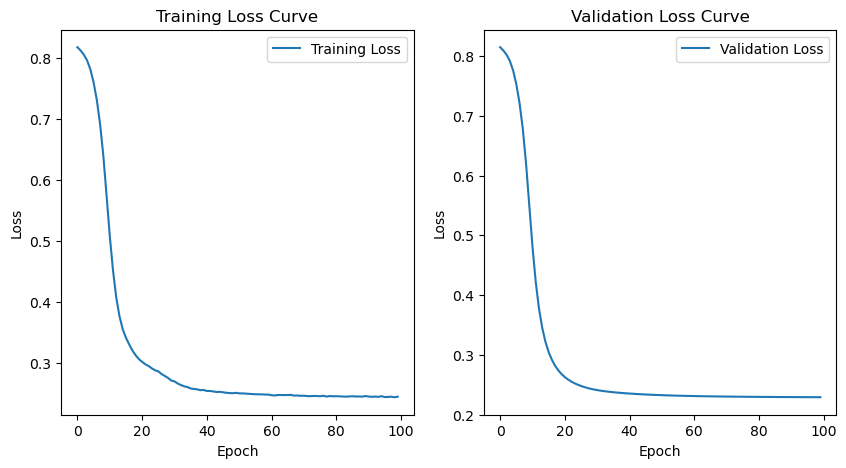

In [165]:
# DataLoaders for batching
train_batch_size = 1024
test_batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=train_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

# Initialize model, criterion, and optimizer
model = PortfolioFCN(input_dim=len(indicators), output_dim=len(stocks))
criterion = SharpeRatioLoss(risk_free_rate=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Train the model
train_losses, val_losses = train_weights(train_loader, val_loader, model, criterion, optimizer, covariance_tensor, expected_returns_tensor, epochs=100)

# Plot loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Curve')
plt.legend()

# Save the figure as a PDF 
plt.savefig("final_config.pdf")

In [166]:
# Test the model
weights = test_weights(test_loader, model, criterion, covariance_tensor, expected_returns_tensor)
print("Optimized Portfolio Weights:", weights)

print(weights.shape)

Test Loss: 0.2292
Optimized Portfolio Weights: [[4.1911656e-09 9.9977499e-01 4.1911656e-09 ... 4.1911656e-09
  4.1911656e-09 4.1911656e-09]
 [1.6193165e-07 9.9891222e-01 1.6193165e-07 ... 1.6193165e-07
  1.6193165e-07 1.6193165e-07]
 [4.7979749e-09 9.9976474e-01 4.7979749e-09 ... 4.7979749e-09
  4.7979749e-09 4.7979749e-09]
 ...
 [3.8268927e-06 9.9572325e-01 3.8268927e-06 ... 3.8268927e-06
  3.8268927e-06 3.8268927e-06]
 [1.3008294e-08 9.9962616e-01 1.3008294e-08 ... 1.3008294e-08
  1.3008294e-08 1.3008294e-08]
 [2.3906043e-08 9.9951446e-01 2.3906043e-08 ... 2.3906043e-08
  2.3906043e-08 2.3906043e-08]]
(8976, 20)


In [167]:
import zipfile
import os

# Define the paths
notebook_name = "amath_482_hw5.ipynb"  
output_zip_name = "amath_482_hw5.zip" 

# Initialize a ZipFile object
with zipfile.ZipFile(output_zip_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Add the notebook
    zipf.write(notebook_name)
    
    for file_name in os.listdir():
        if file_name != notebook_name and not file_name.endswith('.zip'):
            zipf.write(file_name)

print(f"Notebook and files zipped into: {output_zip_name}")

Notebook and files zipped into: amath_482_hw5.zip
